In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt 
from matplotlib import rcParams 

import pandas as pd
import multiprocessing as mp
import astropy.coordinates as coord
import numpy.ma as ma

# Tools for computing derived quantities, such as absolute magnitude and distance

In [2]:
def getMainSequenceAbsMag(gi,FeH): 
    """Get absolute magnitude for main sequence stars using eqs. 2, 5, and 7 from
       Ivezic et al. 2008 (ApJ, 684, 287)"""

    # valid for 0.2 < g-i < 4.0 
    Mr0 = -5.06 + 14.32*gi - 12.97*gi**2 + 6.127*gi**3 - 1.267*gi**4 + 0.0967*gi**5
    # offset for metallicity, valid for -2.5 < FeH < 0.2
    Mr = Mr0 + 4.50 - 1.11*FeH - 0.18*FeH**2
    return Mr

def getMainSequenceDistanceKpc(gi,FeH,r): 
    """Get stellar distance in kpc"""
    
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    # distance in kpc
    Dkpc = 0.01 * 10**(0.2*(r-Mr))
    return Dkpc

def getMainSequenceAppMagforDistanceKpc(gi,FeH,Dkpc): 
    """Get apparent mag array for g-i array, given FeH and Dkpc"""
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    return Mr + 5*np.log10(100*Dkpc)  

def getPhotomMetallicityBond2010(ug,gr):
    """Get stellar photometric metallicity from the SDSS u, g and r magnitudes
       using eq.A1 from Bond et al. 2010 (ApJ, 716, 1):
       [Fe/H]=A+Bx+Cy+Dxy+Ex2+Fy2+Gx2y+Hxy2+Ix3+Jy3
       with x = (u-g) and y = (g-r), and the best-fit coefficients 
       (A-J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20).
       This expression if valid only for g-r<0.6; for redder stars uses [Fe/H] = -0.6.
       Beyond the limits -2.5 and 0.5, use the limits. Add Gaussian noise with rms=0.1"""

    # aux variables
    x = ug
    y = gr
    xy = x*y
    x2 = x*x
    y2 = y*y
    x2y = x*x*y
    xy2 = x*y*y
    y3 = y*y*y

    A = -13.13  
    B =  14.09
    C =  28.04
    D =  -5.51
    E =  -5.90
    F = -58.68
    G =   9.14
    H = -20.61
    I =  58.20
    FeH = A + B*x + C*y + D*xy + E*x2 + F*y2 + G*x2y + H*xy2 + I*y3 
    # add Gaussian noise (rms=0.1 dex) 
    np.random.seed(666) 
    b = np.random.randn(FeH.shape[0])  # Gaussian
    FeH = FeH + 0.1*b
    FeH[gr>0.6] = -0.6
    FeH[FeH < -2.5] = -2.5
    FeH[FeH > 0.5] = 0.5
    return FeH    

# More analysis tools

In [3]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin


def plotCoded2DmapRAbins(x, y, z, RA, xMin, xMax, yMin, yMax, nBin, xLabel, yLabel, cLabel, median=True):

    rcParams['ytick.labelsize'] = 15
    rcParams['xtick.labelsize'] = 15
    rcParams['axes.labelsize'] = 20
    rcParams['axes.linewidth'] = 2
    rcParams['font.size'] = 15
    rcParams['axes.titlesize'] = 18

    def selectRAbin(x, y, z, RA, RAmin, RAmax): 
        xB = x[(RA>RAmin)&(RA<RAmax)]
        yB = y[(RA>RAmin)&(RA<RAmax)]
        zB = z[(RA>RAmin)&(RA<RAmax)]
        return xB, yB, zB 

    # define plotting space 
    fig = plt.figure(figsize=(15,8)) 
    fig.subplots_adjust(hspace=0.35, top=0.85, bottom=0.1, left=0.12, right=0.93)
    # location of the colorbar in Figure units 
    bottom, height =  0.97, 0.02 
            
    # calculate the 2D statistics 
    if (median):
        statsName = 'median'   
        cLlabel = 'median ' + cLabel
    else:
        statsName = 'rms' 
        cLlabel = 'rms for ' + cLabel
         
    RAmin = np.zeros(6) 
    RAmin[0] = 20
    RAmin[1] = 10
    RAmin[2] = 0
    RAmin[3] = 350
    RAmin[4] = 340
    RAmin[5] = 330


    for i in range(0,6):
        ax = plt.subplot(2,3,i+1) 
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        title = 'RA'+str(RAmin[i])+'-'+str(RAmin[i]+10)
        ax.set_title(title)
        plt.xlim([xMin,xMax])
        plt.ylim([yMax,yMin])

        # extract the 2D statistic,  and location of bin edges 
        xB, yB, zB = selectRAbin(x, y, z, RA, RAmin[i], RAmin[i]+10.0)
        # print('i:', i, np.size(xB), np.size(yB), np.size(zB))
        stats =  binned_statistic_2d(xB, yB, zB, statistic=statsName, bins=nBin)
        H, xedges, yedges= stats[0].T , stats[1], stats[2]

        # span the grid from bin edges 
        X_, Y_ = np.meshgrid(xedges, yedges)
        cmap = 'viridis'
        cmap = 'jet'


        # plot the image 
        image = ax.pcolormesh(X_, Y_, H, cmap=cmap)

        if (i==0): 
            # extract the left corner and width of colorbar from axis - 
            # works well for multiple axes since location of 
            # new axis must be in figure units 
            l,b,w,h = ax.get_position().bounds
            cax = fig.add_axes([l,bottom,w,height])
            # plot the colorbar 
            plt.colorbar(mappable = image, cax = cax, orientation='horizontal', label=cLlabel)
'''         
        if (1):
            giGrid = np.linspace(0.0,4.5,100)
            FeH = -1.5
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,0.3)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,1.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,3.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,10.0)
            ax.plot(giGrid, rD)
            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,30.0)
            ax.plot(giGrid, rD)

'''
 #   plt.savefig('Fig_Coded2DmapRAbins.png', bbox_inches='tight', dpi=100)

'         \n        if (1):\n            giGrid = np.linspace(0.0,4.5,100)\n            FeH = -1.5\n            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,0.3)\n            ax.plot(giGrid, rD)\n            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,1.0)\n            ax.plot(giGrid, rD)\n            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,3.0)\n            ax.plot(giGrid, rD)\n            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,10.0)\n            ax.plot(giGrid, rD)\n            rD = getMainSequenceAppMagforDistanceKpc(giGrid,FeH,30.0)\n            ax.plot(giGrid, rD)\n\n'

In [4]:
cd ../Downloads/

/Users/tianqiu/Downloads


In [5]:
m=pd.read_csv('catalog/m_both_stars_i<24.2_ira_c.csv')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
gi=m.g_psfflux_mag-m.i_psfflux_mag
gr=m.g_psfflux_mag-m.r_psfflux_mag
ug=m.psfmag_u-m.g_psfflux_mag
FeH=getPhotomMetallicityBond2010(ug,gr)
Dkpc=getMainSequenceDistanceKpc(gi,FeH,m.r_psfflux_mag)
ra=(m.i_sdsscentroid_ra.values-m.ra_2.values)*3600000/10
dec=(m.i_sdsscentroid_dec.values-m.dec_2.values)*3600000/10

In [7]:
m['ug']=ug
m['gr']=gr
m['gi']=gi
m['FeH']=FeH
m['Dkpc']=Dkpc
m['pmra']=ra
m['pmdec']=dec

In [8]:
#For those valid region.
m=m[(m.gi>0.2)&(m.gi<4)]
m=m[(m.FeH<0.2)&(m.FeH>-2.5)]

In [9]:
#mb for blue star 0.2<gr<0.6
mb=m[(m.gr<0.6)&(m.gr>0.2)]
#mr for red star 1.2<gr<1.6
mr=m[(m.gr>1.2)&(m.gr<1.6)]

In [10]:
m.to_csv('catalog/m_both_stars_i<24.2_ira_c_dist.csv')

Text(0, 0.5, 'r-i')

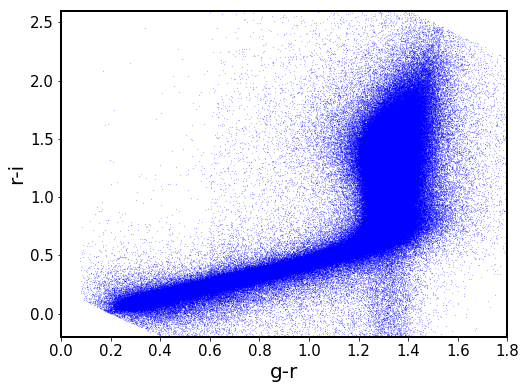

In [48]:
#color
gr = m.gr
ri = m.r_psfflux_mag-m.i_psfflux_mag
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gr, ri, s=0.01, c='blue')
ax.set_xlim(0.0,1.8)
ax.set_ylim(-0.2,2.6)
ax.set_xlabel('g-r')
ax.set_ylabel('r-i')

Text(0, 0.5, 'M_r')

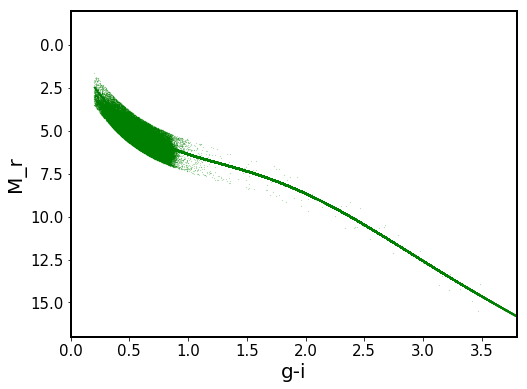

In [49]:
#Absolute magnitude r-band vs. g-i 
gi = m.gi
D = m.Dkpc*1000
Mr = m.r_psfflux_mag - 5*np.log10(D) + 5 


# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi, Mr, s=0.01, c='green')
#ax.scatter(gi1, Mr1, s=0.01, c='blue')
#ax.scatter(gi2, Mr2, s=0.01, c='red')

ax.set_xlim(0.0,3.8)
ax.set_ylim(17,-2)
ax.set_xlabel('g-i')
ax.set_ylabel('M_r')

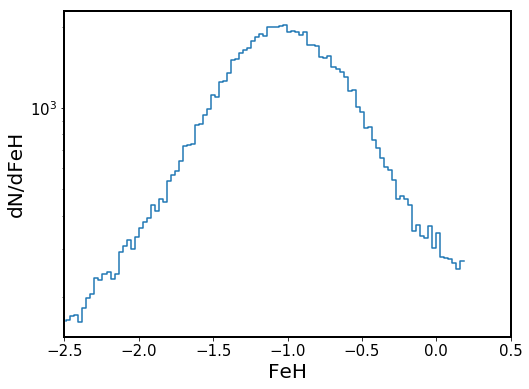

In [50]:
##metallicity distributions for blue stars, subtracting g-r>0.6
FeH = m[m.gr<0.6].FeH
 
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist, bins = np.histogram(FeH, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   


ax.set_xlabel('FeH')
ax.set_ylabel('dN/dFeH')
ax.set_xlim(-2.5, 0.5)
ax.set_yscale('log')
plt.show()

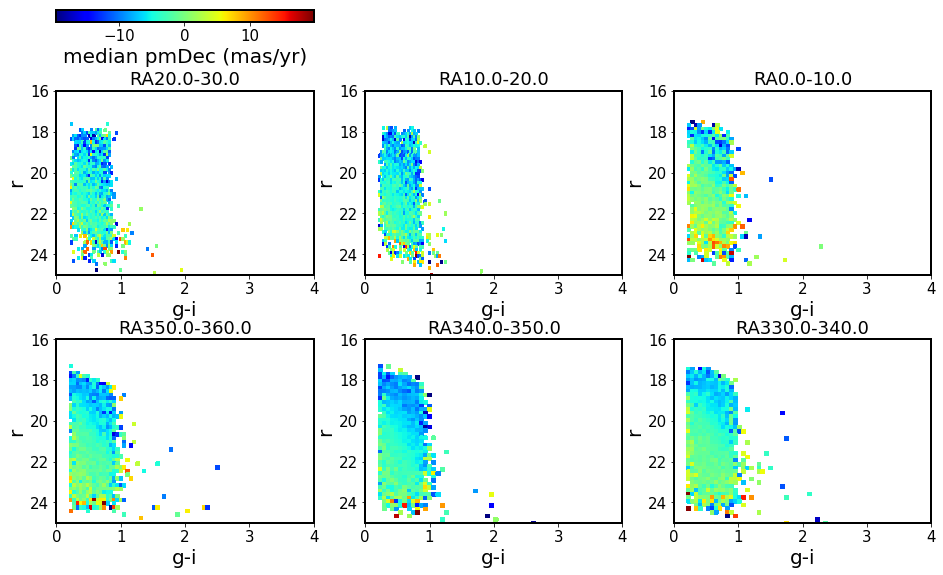

In [16]:
## let's now look at the median proper motions in the r vs. g-i diagram
## for subsamples selected by R.A.
## note: the lines correspond to D = 0.3, 1.0, 3.0, 10 and 30 kpc 

pmRA = mb.pmra
pmDec = mb.pmdec
# remove very large proper motions that make plots ugly...

pmRAOK = pmRA[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
pmDecOK = pmDec[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
giOK = mb.gi[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
rOK = mb.r_psfflux_mag[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 
RAOK = mb.i_sdsscentroid_ra[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 
FeHOK = mb.FeH[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 
plotCoded2DmapRAbins(giOK, rOK, pmDecOK, RAOK, 0.0, 4.0, 16, 25, 50, 'g-i', 'r', 'pmDec (mas/yr)')
plt.savefig('distance/pmDec_r_vs_g-i.png')

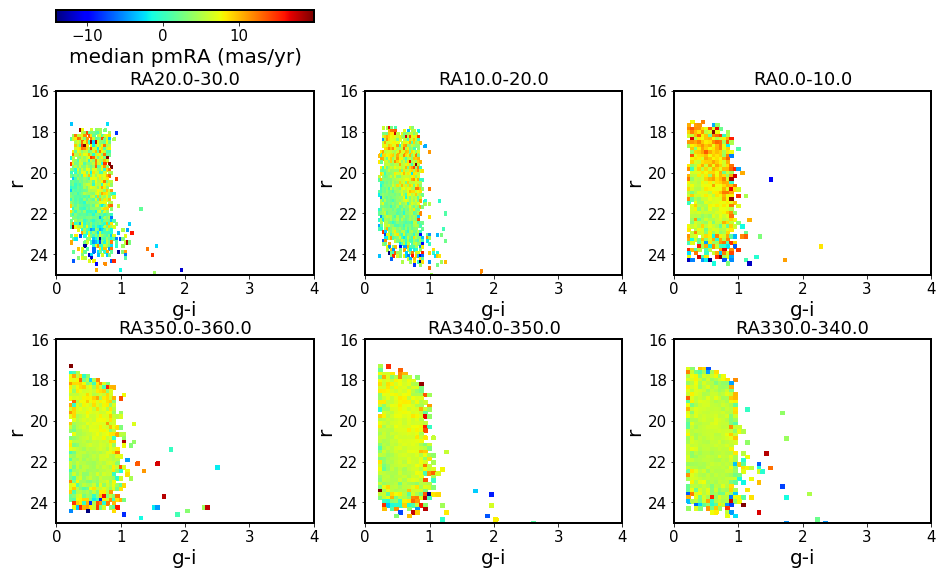

In [17]:
plotCoded2DmapRAbins(giOK, rOK, pmRAOK, RAOK, 0.0, 4.0, 16, 25, 50, 'g-i', 'r', 'pmRA (mas/yr)')
plt.savefig('distance/pmRA_r_vs_g-i.png')

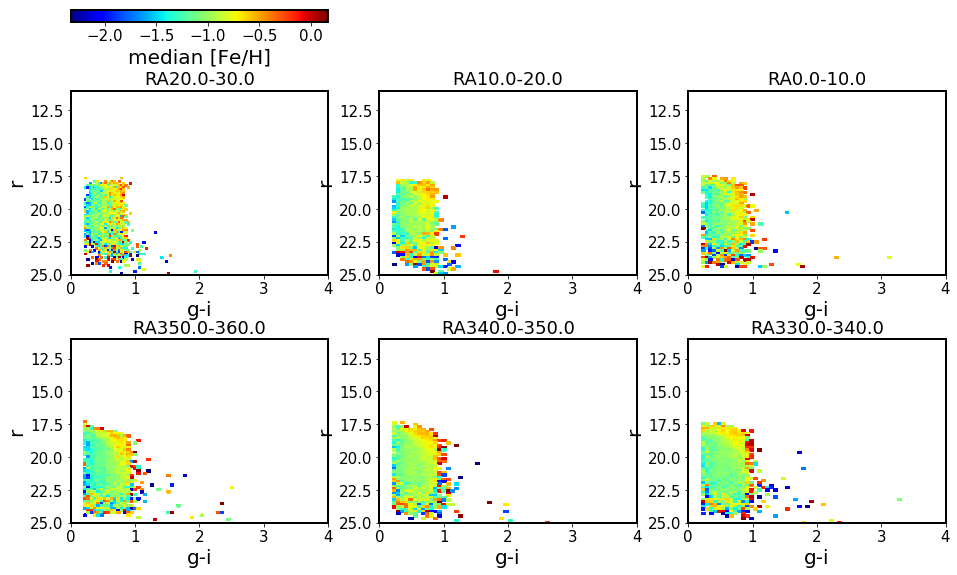

In [18]:
#Fe/H 
cond=(mb.Dkpc>0)
gi = mb[cond].gi
r = mb[cond].r_psfflux_mag
FeH = mb[cond].FeH
RA = mb[cond].i_sdsscentroid_ra
plotCoded2DmapRAbins(gi, r, FeH, RA, 0.0, 4.0, 11, 25, 50, 'g-i', 'r', '[Fe/H]')
plt.savefig('distance/FeH_r_vs_g-i.png')

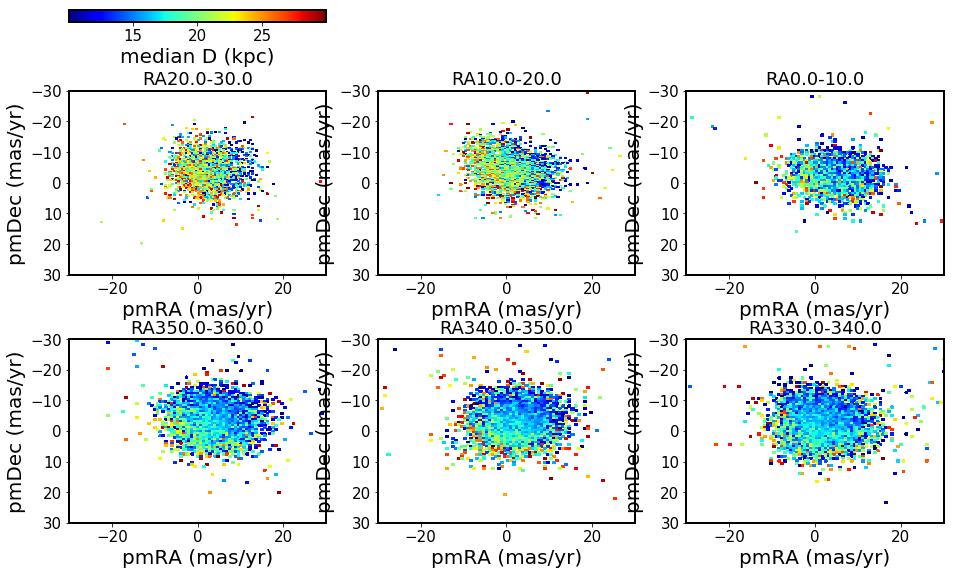

In [19]:
## The pmdec vs. pmra distribution for 10-30kpc blue stars
cond = (mb.Dkpc>10)&(mb.Dkpc<30)
raB = mb[cond].i_sdsscentroid_ra
DappB = mb[cond].Dkpc
pmRAB = mb[cond].pmra
pmDecB = mb[cond].pmdec
plotCoded2DmapRAbins(pmRAB, pmDecB, DappB, raB, -30, 30, -30, 30, 200, 'pmRA (mas/yr)', 'pmDec (mas/yr)', 'D (kpc)')
plt.savefig('distance/pmDec_vs_pmRA.png')

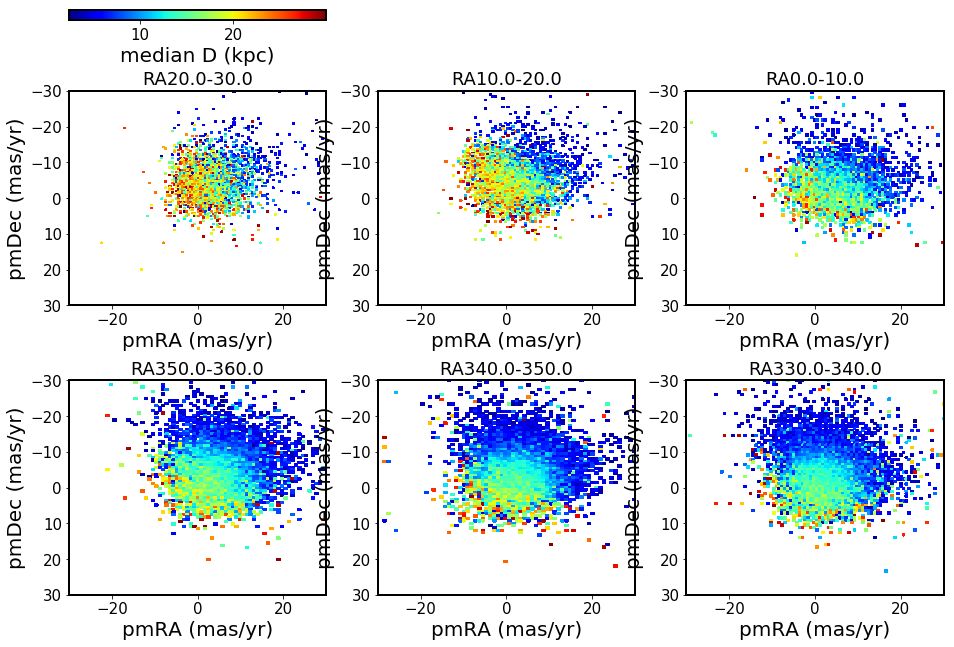

In [61]:
## The pmdec vs. pmra distribution for 2-30kpc blue stars
cond = (mb.Dkpc>2)&(mb.Dkpc<30)
raB = mb[cond].i_sdsscentroid_ra
DappB = mb[cond].Dkpc
pmRAB = mb[cond].pmra
pmDecB = mb[cond].pmdec
plotCoded2DmapRAbins(pmRAB, pmDecB, DappB, raB, -30, 30, -30, 30, 200, 'pmRA (mas/yr)', 'pmDec (mas/yr)', 'D (kpc)')

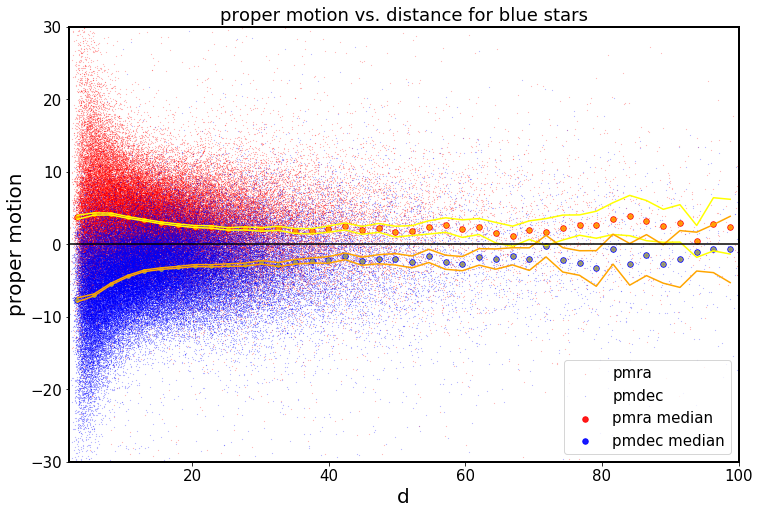

In [20]:
# Proper motion vs. r for stars with 0.2 < g-r < 0.6 (blue star)
r = mb.r_psfflux_mag
gr = mb.gr
D = mb.Dkpc
pmra = mb.pmra
pmdec = mb.pmdec
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(2,100)
ax.set_ylim(-30,30)
ax.set_xlabel('d')
ax.set_ylabel('proper motion')
# binned medians to be more quantitative 
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 2, 100, 40, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 2, 100, 40, 0)
ax.scatter(x1Bin, m1edianBin, s=30.0, c='red', alpha=0.9, label='pmra median')
ax.scatter(x1Bin, m1edianBin, s=15.0, c='yellow', alpha=0.5)
ax.scatter(x2Bin, m2edianBin, s=30.0, c='blue', alpha=0.9, label='pmdec median')
ax.scatter(x2Bin, m2edianBin, s=15.0, c='yellow', alpha=0.5)
T1woSigP = m1edianBin + 2*s1igGbin
T1woSigM = m1edianBin - 2*s1igGbin 
T2woSigP = m2edianBin + 2*s2igGbin
T2woSigM = m2edianBin - 2*s2igGbin 
ax.plot(x1Bin, T1woSigP, c='yellow')
ax.plot(x1Bin, T1woSigM, c='yellow')
ax.plot(x2Bin, T2woSigP, c='orange')
ax.plot(x2Bin, T2woSigM, c='orange')
xL = np.linspace(0,100)
ax.plot(xL, 0*xL+0.00, c='black')
plt.title('proper motion vs. distance for blue stars')
plt.legend()
plt.savefig('distance/pm_vs_d_bluestar.png')

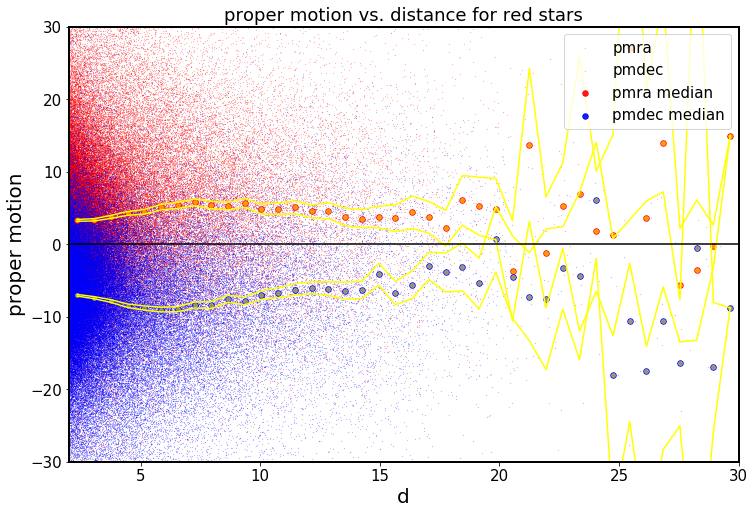

In [22]:
# Proper motion vs. r for red stars 
r = mr.r_psfflux_mag
gr = mr.gr
D = mr.Dkpc
pmra = mr.pmra
pmdec = mr.pmdec
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(2,30)
ax.set_ylim(-30,30)
ax.set_xlabel('d')
ax.set_ylabel('proper motion')
# binned medians to be more quantitative 
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 2, 30, 40, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 2, 30, 40, 0)
ax.scatter(x1Bin, m1edianBin, s=30.0, c='red', alpha=0.9, label='pmra median')
ax.scatter(x1Bin, m1edianBin, s=15.0, c='yellow', alpha=0.5)
ax.scatter(x2Bin, m2edianBin, s=30.0, c='blue', alpha=0.9, label='pmdec median')
ax.scatter(x2Bin, m2edianBin, s=15.0, c='yellow', alpha=0.5)
T1woSigP = m1edianBin + 2*s1igGbin
T1woSigM = m1edianBin - 2*s1igGbin 
T2woSigP = m2edianBin + 2*s2igGbin
T2woSigM = m2edianBin - 2*s2igGbin 
ax.plot(x1Bin, T1woSigP, c='yellow')
ax.plot(x1Bin, T1woSigM, c='yellow')
ax.plot(x2Bin, T2woSigP, c='yellow')
ax.plot(x2Bin, T2woSigM, c='yellow')
xL = np.linspace(0,100)
ax.plot(xL, 0*xL+0.00, c='black')
plt.title('proper motion vs. distance for red stars')
plt.legend()
plt.savefig('distance/pm_vs_d_redstar_2.png')

In [ ]:
#above are the results using u-band in sdss and other bands in HSC
#below are the results of all magnitudes in sdss bands

Text(0, 0.5, 'r-i')

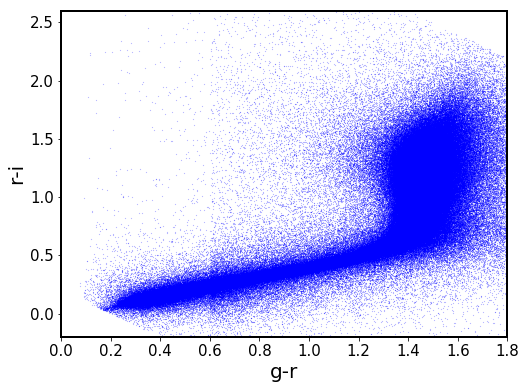

In [223]:
#color
gr = m.gr
ri = m.psfMag_r-m.psfMag_i
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gr, ri, s=0.01, c='blue')
ax.set_xlim(0.0,1.8)
ax.set_ylim(-0.2,2.6)
ax.set_xlabel('g-r')
ax.set_ylabel('r-i')

Text(0, 0.5, 'M_r')

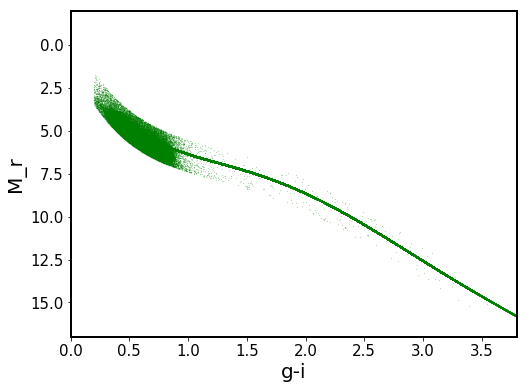

In [225]:
#Absolute magnitude r-band vs. g-i 
gi = m.gi
D = m.Dkpc*1000
Mr = m.psfMag_r - 5*np.log10(D) + 5 


# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi, Mr, s=0.01, c='green')
#ax.scatter(gi1, Mr1, s=0.01, c='blue')
#ax.scatter(gi2, Mr2, s=0.01, c='red')

ax.set_xlim(0.0,3.8)
ax.set_ylim(17,-2)
ax.set_xlabel('g-i')
ax.set_ylabel('M_r')

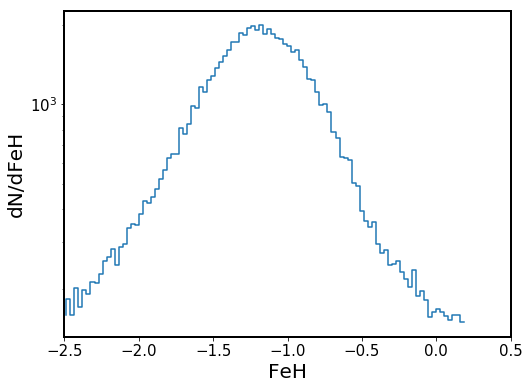

In [226]:
##metallicity distributions for blue stars, subtracting g-r>0.6
FeH = m[m.gr<0.6].FeH
 
fig,ax = plt.subplots(1,1,figsize=(8,6))
hist, bins = np.histogram(FeH, bins=100)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   


ax.set_xlabel('FeH')
ax.set_ylabel('dN/dFeH')
ax.set_xlim(-2.5, 0.5)
ax.set_yscale('log')
plt.show()

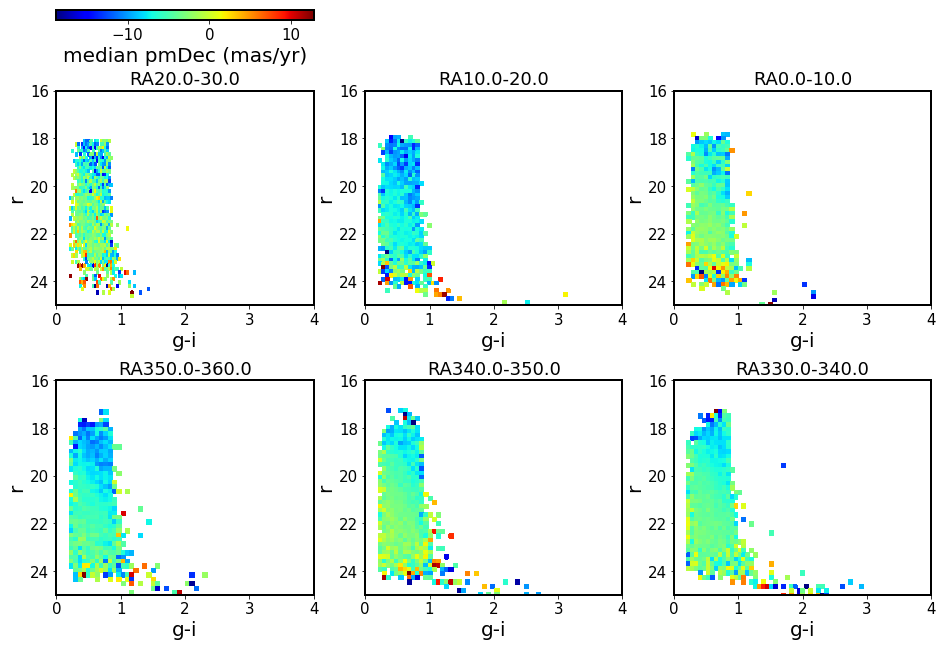

In [34]:
## let's now look at the median proper motions in the r vs. g-i diagram
## for subsamples selected by R.A.
## note: the lines correspond to D = 0.3, 1.0, 3.0, 10 and 30 kpc 

pmRA = mb.pmra
pmDec = mb.pmdec
# remove very large proper motions that make plots ugly...

pmRAOK = pmRA[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
pmDecOK = pmDec[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
giOK = mb.gi[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)]
rOK = mb.r[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 
RAOK = mb.ra_2[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 
FeHOK = mb.FeH[(np.abs(pmRA)<20)&(np.abs(pmDec)<20)] 
plotCoded2DmapRAbins(giOK, rOK, pmDecOK, RAOK, 0.0, 4.0, 16, 25, 50, 'g-i', 'r', 'pmDec (mas/yr)')
plt.savefig('distance/pmDec_r_vs_g-i.png')

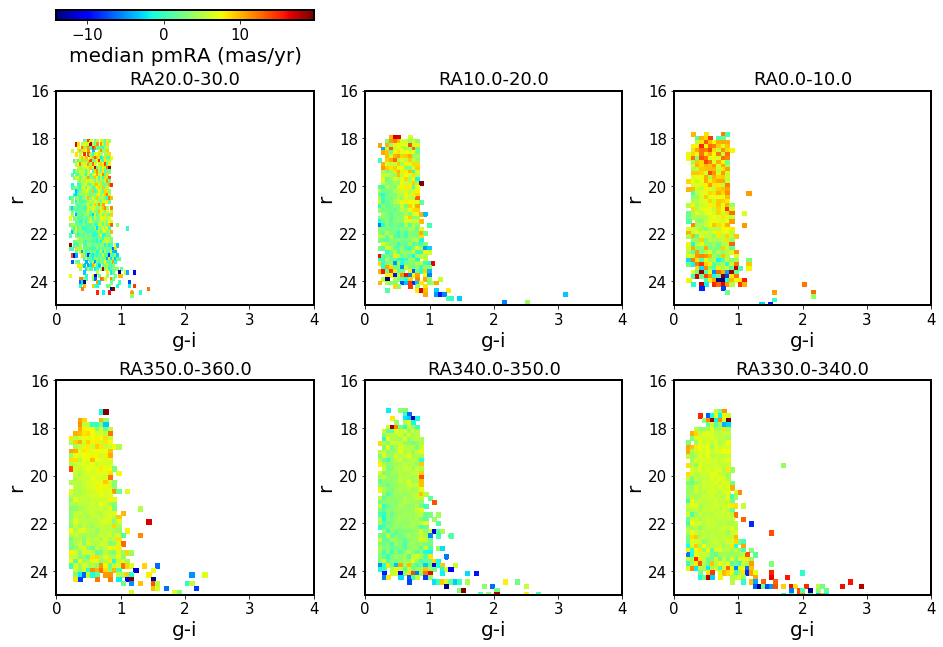

In [35]:
plotCoded2DmapRAbins(giOK, rOK, pmRAOK, RAOK, 0.0, 4.0, 16, 25, 50, 'g-i', 'r', 'pmRA (mas/yr)')
plt.savefig('distance/pmRA_r_vs_g-i.png')

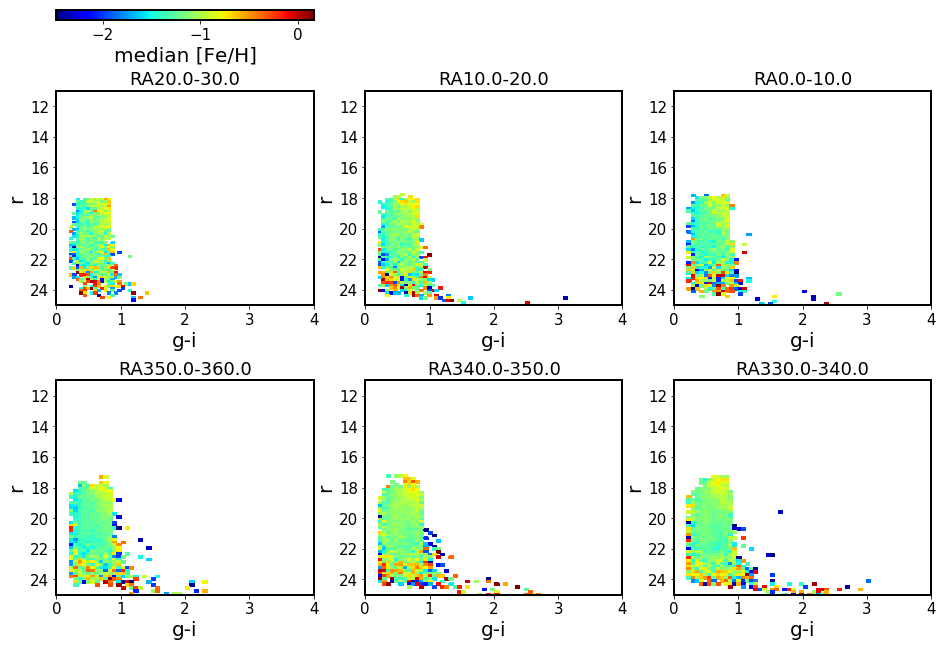

In [36]:
#Fe/H 
cond=(mb.Dkpc>0)
gi = mb[cond].gi
r = mb[cond].psfMag_r
FeH = mb[cond].FeH
RA = mb[cond].ra_2
plotCoded2DmapRAbins(gi, r, FeH, RA, 0.0, 4.0, 11, 25, 50, 'g-i', 'r', '[Fe/H]')
plt.savefig('distance/FeH_r_vs_g-i.png')

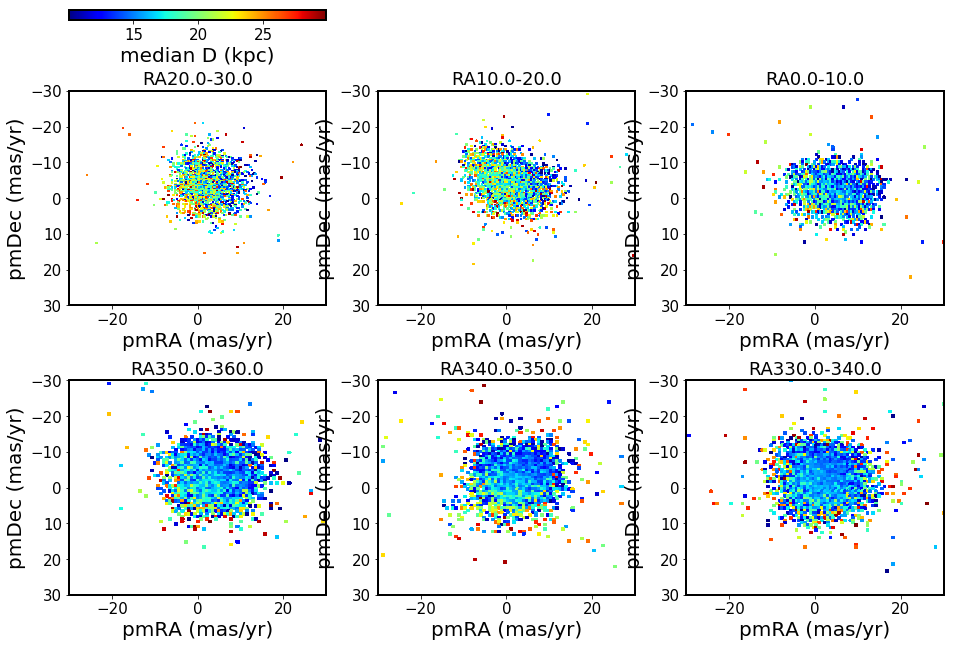

In [37]:
## The pmdec vs. pmra distribution for 10-30kpc blue stars
cond = (mb.Dkpc>10)&(mb.Dkpc<30)
raB = mb[cond].ra_2
DappB = mb[cond].Dkpc
pmRAB = mb[cond].pmra
pmDecB = mb[cond].pmdec
plotCoded2DmapRAbins(pmRAB, pmDecB, DappB, raB, -30, 30, -30, 30, 200, 'pmRA (mas/yr)', 'pmDec (mas/yr)', 'D (kpc)')
plt.savefig('distance/pmDec_vs_pmRA.png')

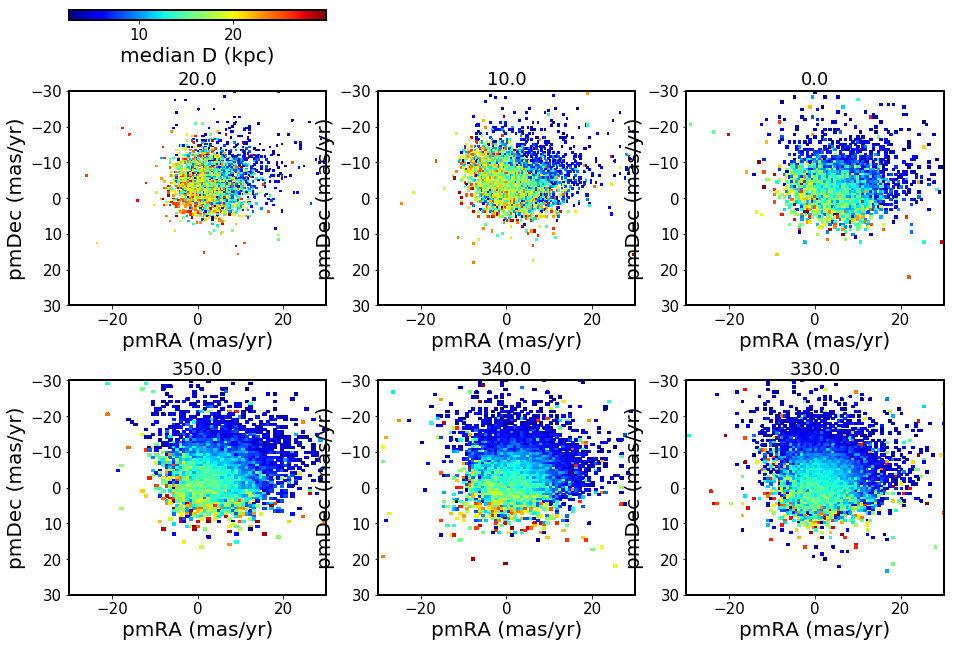

In [319]:
## The pmdec vs. pmra distribution for 2-30kpc blue stars
cond = (mb.Dkpc>2)&(mb.Dkpc<30)
raB = mb[cond].ra_2
DappB = mb[cond].Dkpc
pmRAB = mb[cond].pmra
pmDecB = mb[cond].pmdec
plotCoded2DmapRAbins(pmRAB, pmDecB, DappB, raB, -30, 30, -30, 30, 200, 'pmRA (mas/yr)', 'pmDec (mas/yr)', 'D (kpc)')

Text(0, 0.5, 'r')

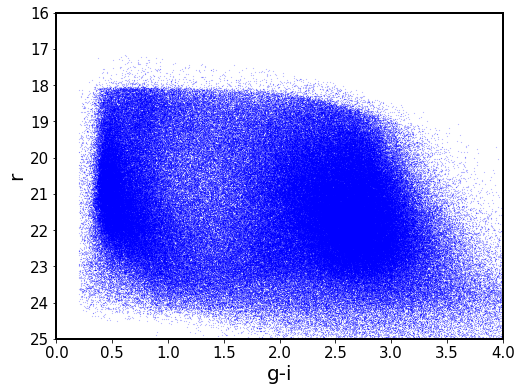

In [264]:
gi = m.gi
r = m.psfMag_r
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi, r, s=0.01, c='blue') 
ax.set_xlim(-0.0,4.0)
ax.set_ylim(25,16)
ax.set_xlabel('g-i')
ax.set_ylabel('r')

Text(0, 0.5, 'r')

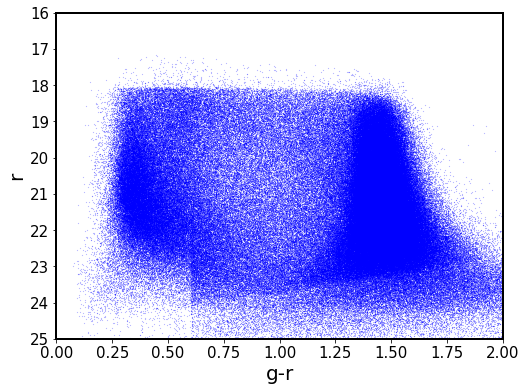

In [284]:
gr = m.gr
r = m.psfMag_r
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gr, r, s=0.01, c='blue') 
ax.set_xlim(-0.0,2.0)
ax.set_ylim(25,16)
ax.set_xlabel('g-r')
ax.set_ylabel('r')

Text(0, 0.5, 'r')

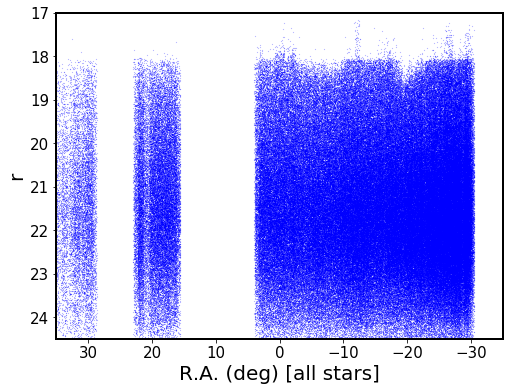

In [263]:
##compare r vs. RA plots for the full sample and the blue subsample, to estimate the RA range where halo definitely dominates
#full sample
r=m.psfMag_r
ra = m.ra_2
dec = m.dec_2
# user wrapped RA to avoid disjoint regions 
raW = np.where(ra > 180, ra-360, ra)   
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, r, s=0.01, c='blue') 
ax.set_xlim(35, -35)
ax.set_ylim(24.5,17)
ax.set_xlabel('R.A. (deg) [all stars]')
ax.set_ylabel('r')

Text(0, 0.5, 'r')

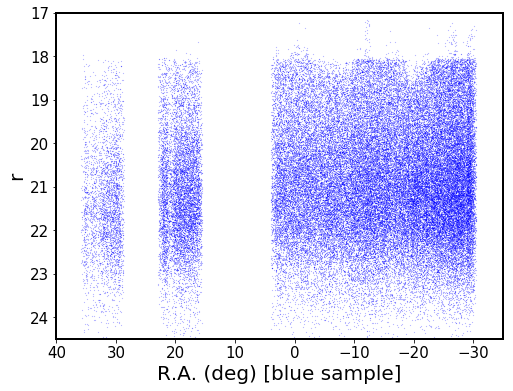

In [293]:
##compare r vs. RA plots for the full sample and the blue subsample, to estimate the RA range where halo definitely dominates
#blue sample
r=mb.psfMag_r
ra = mb.ra_2
dec = mb.dec_2
# user wrapped RA to avoid disjoint regions 
raW = np.where(ra > 180, ra-360, ra)   
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, r, s=0.01, c='blue') 
ax.set_xlim(40, -35)
ax.set_ylim(24.5,17)
ax.set_xlabel('R.A. (deg) [blue sample]')
ax.set_ylabel('r')

Text(0, 0.5, 'r')

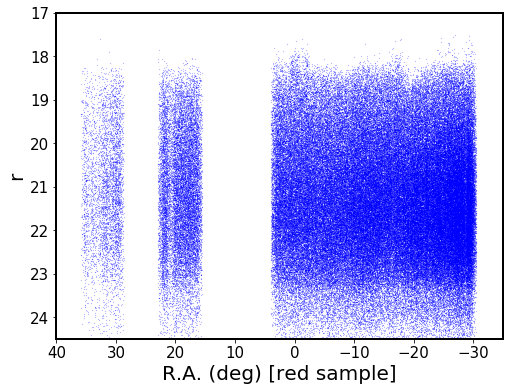

In [292]:
##compare r vs. RA plots for the full sample and the blue subsample, to estimate the RA range where halo definitely dominates
#red sample
r=mr.psfMag_r
ra = mr.ra_2
dec = mr.dec_2
# user wrapped RA to avoid disjoint regions 
raW = np.where(ra > 180, ra-360, ra)   
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, r, s=0.01, c='blue') 
ax.set_xlim(40, -35)
ax.set_ylim(24.5,17)
ax.set_xlabel('R.A. (deg) [red sample]')
ax.set_ylabel('r')

(array([  547.,  8060., 11591., 16932., 19894., 12857.,  3985.,   664.,
          104.,    25.]),
 array([17.17439 , 18.119927, 19.065464, 20.011001, 20.956538, 21.902075,
        22.847612, 23.793149, 24.738686, 25.684223, 26.62976 ]),
 <a list of 10 Patch objects>)

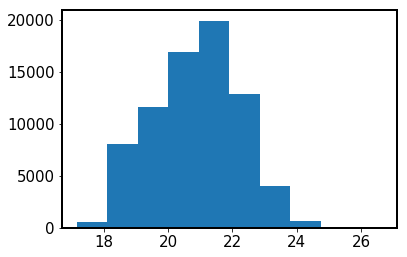

In [294]:
plt.hist(mb.psfMag_r)

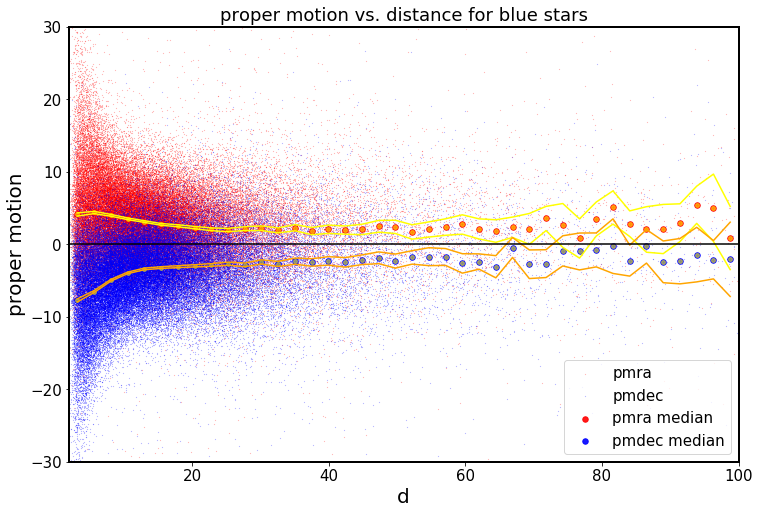

In [39]:
# Proper motion vs. r for stars with 0.2 < g-r < 0.6 (blue star)
r = mb.psfMag_r
gr = mb.gr
D = mb.Dkpc
pmra = mb.pmra
pmdec = mb.pmdec
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(2,100)
ax.set_ylim(-30,30)
ax.set_xlabel('d')
ax.set_ylabel('proper motion')
# binned medians to be more quantitative 
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 2, 100, 40, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 2, 100, 40, 0)
ax.scatter(x1Bin, m1edianBin, s=30.0, c='red', alpha=0.9, label='pmra median')
ax.scatter(x1Bin, m1edianBin, s=15.0, c='yellow', alpha=0.5)
ax.scatter(x2Bin, m2edianBin, s=30.0, c='blue', alpha=0.9, label='pmdec median')
ax.scatter(x2Bin, m2edianBin, s=15.0, c='yellow', alpha=0.5)
T1woSigP = m1edianBin + 2*s1igGbin
T1woSigM = m1edianBin - 2*s1igGbin 
T2woSigP = m2edianBin + 2*s2igGbin
T2woSigM = m2edianBin - 2*s2igGbin 
ax.plot(x1Bin, T1woSigP, c='yellow')
ax.plot(x1Bin, T1woSigM, c='yellow')
ax.plot(x2Bin, T2woSigP, c='orange')
ax.plot(x2Bin, T2woSigM, c='orange')
xL = np.linspace(0,100)
ax.plot(xL, 0*xL+0.00, c='black')
plt.title('proper motion vs. distance for blue stars')
plt.legend()
plt.savefig('distance/pm_vs_d_bluestar.png')

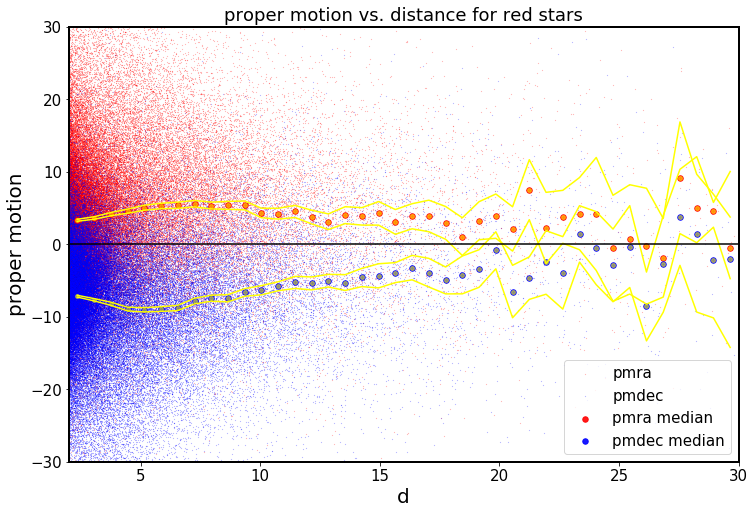

In [41]:
# Proper motion vs. r for red stars 
r = mr.psfMag_r
gr = mr.gr
D = mr.Dkpc
pmra = mr.pmra
pmdec = mr.pmdec
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(D, pmra, s=0.01, c='red', label='pmra')
ax.scatter(D, pmdec, s=0.01, c='blue', label='pmdec')
ax.set_xlim(2,30)
ax.set_ylim(-30,30)
ax.set_xlabel('d')
ax.set_ylabel('proper motion')
# binned medians to be more quantitative 
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(D, pmra, 2, 30, 40, 0)
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(D, pmdec, 2, 30, 40, 0)
ax.scatter(x1Bin, m1edianBin, s=30.0, c='red', alpha=0.9, label='pmra median')
ax.scatter(x1Bin, m1edianBin, s=15.0, c='yellow', alpha=0.5)
ax.scatter(x2Bin, m2edianBin, s=30.0, c='blue', alpha=0.9, label='pmdec median')
ax.scatter(x2Bin, m2edianBin, s=15.0, c='yellow', alpha=0.5)
T1woSigP = m1edianBin + 2*s1igGbin
T1woSigM = m1edianBin - 2*s1igGbin 
T2woSigP = m2edianBin + 2*s2igGbin
T2woSigM = m2edianBin - 2*s2igGbin 
ax.plot(x1Bin, T1woSigP, c='yellow')
ax.plot(x1Bin, T1woSigM, c='yellow')
ax.plot(x2Bin, T2woSigP, c='yellow')
ax.plot(x2Bin, T2woSigM, c='yellow')
xL = np.linspace(0,100)
ax.plot(xL, 0*xL+0.00, c='black')
plt.title('proper motion vs. distance for red stars')
plt.legend()
plt.savefig('distance/pm_vs_d_redstar.png')

In [167]:
rz=x.r_psfflux_mag-x.z_psfflux_mag

In [168]:
gr=x.g_psfflux_mag-x.r_psfflux_mag

In [169]:
gz=x.g_psfflux_mag-x.z_psfflux_mag

In [170]:
ug=x.psfmag_u-x.g_psfflux_mag

In [171]:
z=x.z_psfflux_mag

In [166]:
x=m.sample(100000)

Text(0, 0.5, 'u-g')

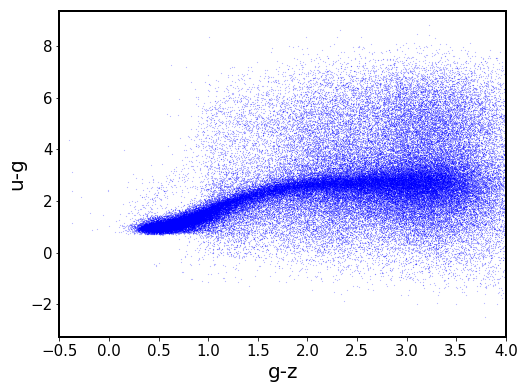

In [177]:

# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gz, ug, s=0.01, c='blue')
ax.set_xlim(-0.5,4)
#ax.set_ylim(-0.2,2.6)
ax.set_xlabel('g-z')
ax.set_ylabel('u-g')


Text(0, 0.5, 'u-g')

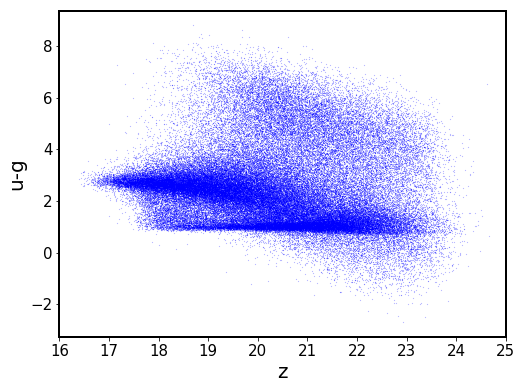

In [176]:
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(z, ug, s=0.01, c='blue')
ax.set_xlim(16,25)
ax.set_xlabel('z')
ax.set_ylabel('u-g')

In [118]:
t=m.iloc[90]

In [128]:
t

# object_id                40576389996372488
ra_1                                0.805981
dec_1                              -0.938243
r_extendedness_value                       0
i_sdsscentroid_ra                   0.805981
i_sdsscentroid_dec                 -0.938243
i_sdsscentroid_rasigma            0.00281804
i_sdsscentroid_decsigma           0.00251879
g_cmodel_mag                      23.9450703
r_cmodel_mag                         22.5786
i_cmodel_mag                         21.7802
z_cmodel_mag                         21.4774
g_cmodel_magsigma                  0.0642175
r_cmodel_magsigma                  0.0113157
i_cmodel_magsigma                 0.00696487
z_cmodel_magsigma                  0.0109105
g_psfflux_mag                        23.9188
r_psfflux_mag                         22.572
i_psfflux_mag                        21.7801
z_psfflux_mag                        21.4728
g_psfflux_magsigma                 0.0590051
r_psfflux_magsigma                 0.0111863
i_psfflux_

In [129]:
v_sun

<CartesianDifferential (d_x, d_y, d_z) in km / s
    (11.1, 232.24, 7.25)>

In [120]:
c1 = SkyCoord(ra=t.ra_2*u.degree, dec=t.dec_2*u.degree, distance=t.Dkpc*u.kpc, pm_ra_cosdec=t.pmra*u.mas/u.year, pm_dec=t.pmdec*u.mas/u.year, radial_velocity=0*u.km/u.s, frame='icrs')
c2 = c1.galactic
rep = c2.cartesian.without_differentials()
c3 = rep.with_differentials(c2.cartesian.differentials['s'] + v_sun)
c4 = coord.Galactic(c3).transform_to(coord.ICRS)

In [121]:
c1

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (0.8060114, -0.9381592, 4.9521031)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-10.95334301, -30.03743957, 0.)>

In [122]:
c2

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    (97.09981562, -61.36804941, 4.9521031)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-21.74600095, -23.43789543, 6.7366137e-14)>

In [123]:
c2.cartesian.differentials

{'s': <CartesianDifferential (d_x, d_y, d_z) in km / s
     (566.26882003, -416.13035544, -263.65115192)>}

In [124]:
c2.galactocentric

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-8.6073787, 2.35476725, -4.31855953)
 (v_x, v_y, v_z) in km / s
    (576.50815443, -183.89049492, -258.24163691)>

In [136]:
coord.Galactic(c3).pm_b

<Quantity -14.72458134 mas / yr>

In [126]:
coord.Galactocentric(c3)

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-0.29329324, 2.35476059, -4.34653963)
 (v_x, v_y, v_z) in km / s
    (577.36882003, -183.89035544, -256.40115192)>

In [4]:
l=pd.read_csv('../Downloads/catalog/m_both_stars_i<24.2_ira_c_dist.csv')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
v_sun = coord.Galactocentric.galcen_v_sun
def subtract(i):
    if i==int(i/10000)*10000:
        print(i)
    t=l.iloc[i]
    c1 = SkyCoord(ra=t.ra_2*u.degree, dec=t.dec_2*u.degree, distance=t.Dkpc*u.kpc, pm_ra_cosdec=t.pmra*u.mas/u.year, pm_dec=t.pmdec*u.mas/u.year, radial_velocity=0*u.km/u.s, frame='icrs')
    c2 = c1.galactic
    rep = c2.cartesian.without_differentials()
    c3 = rep.with_differentials(c2.cartesian.differentials['s'] + v_sun)
    c4 = coord.Galactic(c3).transform_to(coord.ICRS)
    t1=t.copy()
    t1['pmra_sm'] = c4.pm_ra_cosdec.value
    t1['pmdec_sm'] = c4.pm_dec.value
    t1['l'] = c2.l.value
    t1['b'] = c2.b.value
    t1['pm_lcosb'] = c2.pm_l_cosb.value
    t1['pm_b'] = c2.pm_b.value
    t1['pm_lcosb_sm'] = coord.Galactic(c3).pm_l_cosb.value
    t1['pm_b_sm'] = coord.Galactic(c3).pm_b.value
    t1['galcen_x'] = c2.galactocentric.x.value
    t1['galcen_y'] = c2.galactocentric.y.value
    t1['galcen_z'] = c2.galactocentric.z.value
    t1['galcen_vx'] = c2.galactocentric.v_x.value
    t1['galcen_vy'] = c2.galactocentric.v_y.value
    t1['galcen_vz'] = c2.galactocentric.v_z.value
    return t1

In [10]:
pool1=mp.Pool(8)
data1=pool1.map(subtract,range(len(l)))
pool1.close()
l2=pd.DataFrame(columns=l.columns)
for i in range(len(data1)):
    l2=l2.append(data1[i])
    if i==int(i/10000)*10000:
        print(str(i)+'*')

0
30000
60000
90000
20000
50000
80000
110000
10000
40000
70000
100000
130000
160000
190000
220000
120000
150000
180000
210000
140000
170000
200000
230000
260000
290000
320000
250000
280000
310000
340000
240000
270000
300000
330000
360000
390000
420000
450000
350000
380000
410000
440000
370000
400000
430000
0*
10000*
20000*
30000*
40000*
50000*
60000*
70000*
80000*
90000*
100000*
110000*
120000*


KeyboardInterrupt: 

In [27]:
len(data1)

459267

In [28]:
tt=pd.DataFrame(data1)

In [13]:
def link(i):
    tt=pd.DataFrame(columns=data1[0].columns)
    for j in range(19136):
        tt=tt.append()

459267

In [33]:
tt.columns

Index(['Unnamed: 0', '# object_id', 'ra_1', 'dec_1', 'r_extendedness_value',
       'i_sdsscentroid_ra', 'i_sdsscentroid_dec', 'i_sdsscentroid_rasigma',
       'i_sdsscentroid_decsigma', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'g_psfflux_mag', 'r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag',
       'g_psfflux_magsigma', 'r_psfflux_magsigma', 'i_psfflux_magsigma',
       'z_psfflux_magsigma', 'a_g', 'a_r', 'a_i', 'a_z', 'col1', 'ra_2',
       'dec_2', 'flags', 'type', 'rowc_r', 'colc_r', 'rowcErr_r', 'colcErr_r',
       'u', 'g', 'r', 'i', 'z', 'err_u', 'err_g', 'err_r', 'err_i', 'err_z',
       'psfmag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'psfmagerr_u', 'psfmagerr_g', 'psfmagerr_r', 'psfmagerr_i',
       'psfmagerr_z', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z', 'Separation', 'ug', 'gr', 'gi',

In [34]:
tt.drop(['Unnamed: 0'],axis=1,inplace=True)

In [36]:
tt.to_csv('../Downloads/catalog/m_both_stars_i<24.2_ira_c_dist_sm.csv')